Tools used: 
- colord (original) https://github.com/refresh-bio/CoLoRd ; compiled with `MEASURE_THREADS_TIMES` defined
- pandas, seqborn, matplotlib, tqdm... 

In [1]:
import os
import time
import gzip
import shutil

import numpy as np
import subprocess as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict, defaultdict
from tqdm import tqdm
from pprint import pprint

from IPython.display import display

sns.set(style='whitegrid', font_scale=1.2)
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['figure.dpi'] = 100

# Data

---

### Human chromosome 1 and MGISEQ2000 sequence data with 30x coverage

#### Reference Statistics:

| Length    | Id           | Description                                                                    |
|-----------|--------------|--------------------------------------------------------------------------------|
| 248956422 | NC_000001.11 | Homo sapiens chromosome 1                                                      |
| 175055    | NT_187361.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG1_UNLOCALIZED |
| 32032     | NT_187362.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG2_UNLOCALIZED |
| 127682    | NT_187363.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG3_UNLOCALIZED |
| 66860     | NT_187364.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG4_UNLOCALIZED |
| 40176     | NT_187365.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG5_UNLOCALIZED |
| 42210     | NT_187366.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG6_UNLOCALIZED |
| 176043    | NT_187367.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG7_UNLOCALIZED |
| 40745     | NT_187368.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG8_UNLOCALIZED |
| 41717     | NT_187369.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG9_UNLOCALIZED |


In [2]:
log_file_patter = 'server_logs/%s/colord_wgs_%st%s.err'
compress_mode = 'pbraw'
data_title = f'Human WGS 300 Gb, Illumina, colord compress-{compress_mode}'
chart_prefix = f'charts/hg/compress-{compress_mode}/server_wgs_'

## Collect `CoLoRd` logs for all files

In [11]:
threads_counts = [2 ** i for i in range(2, 6)]
# server_environments = ['itmo', 'ssc']
server_environments = ['ssc']

In [12]:
logs, logs_r = [], []

for server_environment in server_environments:
    for threads_count in threads_counts:
        logs.append(log_file_patter % (server_environment, threads_count, ''))
#         logs_r.append(log_file_patter % (server_environment, threads_count, '_ref'))

## Parsing log code

In [13]:
def parse_log_file(log):
    def construct_dict_(lines):
        return dict(map(str.strip, line.split(':', 1)) for line in lines)
    
    with open(log) as f:
        # messy hack with \t and dict

        lines_tab, lines_no_tab = [], []
        for line in f:
            if ':' in line and line[0] != '#':
                (lines_no_tab, lines_tab)[line[0] == '\t'].append(line)
        
        return (construct_dict_(lines_no_tab), construct_dict_(lines_tab))

## Calculate Total Time

In [14]:
# calculating stats for every file
def calculate_time_stats(threads_counts, server_environments, logs):   
    stats = defaultdict(list)
    i = 0
    for server_environment in server_environments:
        for threads_count in threads_counts:
            log, log_tab = parse_log_file(logs[i])
            
            stats['Threads'].append(threads_count)
            stats['Server Environment'].append(server_environment)
            stats['Total time, s'].append(float(log['Total time'][:-1]))
            i += 1
                            
    return stats
        
time_stats = calculate_time_stats(threads_counts, server_environments, logs)
# time_stats_r = calculate_time_stats(threads_counts, server_environments, logs_r)

In [15]:
df = pd.DataFrame.from_dict(time_stats)
df['Reference'] = False

# df_r = pd.DataFrame.from_dict(time_stats_r)
# df_r['Reference'] = True

# df_time = pd.concat([df, df_r]).reset_index()
df_time = df
df_time

,Threads,Server Environment,"Total time, s",Reference
0,4,ssc,16003.20,False
1,8,ssc,10984.70,False
2,16,ssc,10069.60,False
3,32,ssc,7687.62,False


## Coverage vs Time Chart

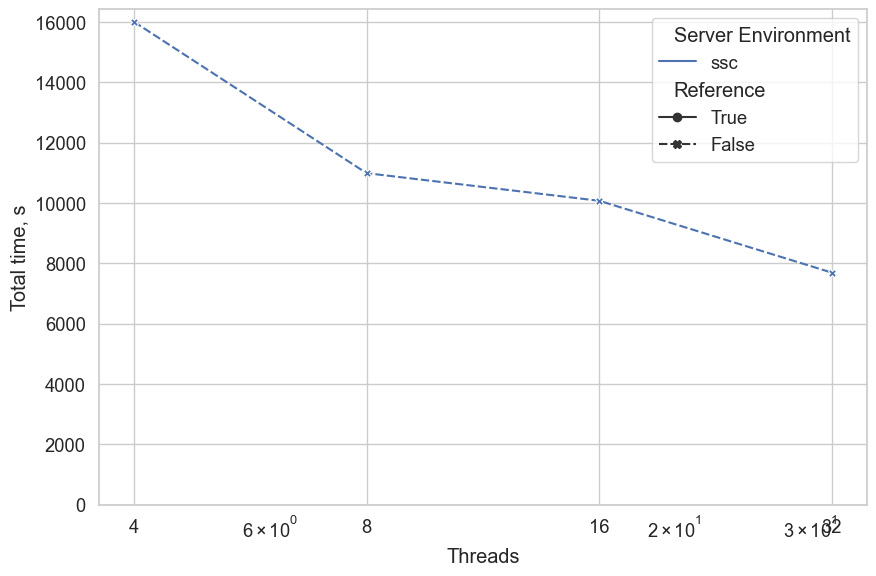

In [16]:
sns.lineplot(data=df_time, x='Threads', y='Total time, s', style='Reference', hue='Server Environment', markers=True, style_order=[True, False])
plt.ylim(ymin=0)
plt.xscale('log')

plt.xticks(threads_counts, [str(c) for c in threads_counts]);

plt.tight_layout();
plt.savefig(chart_prefix + 'threads-vs-time.pdf');